# Experiment 6
In this experiment, the adversarial learning technique is dropped altogether, a single Variational Graph-based auto-encoder is used, using the torch geometry implementation of the VGAE

VGAE proved to be inferior (to be tested) so back to experimenting with a model written from scratch

In [1]:
!ls ../../../Projects/data/WADI/

 table_WADI.pdf       'WADI.A1_9 Oct 2017'    WADI_attackdataLABLE.csv
 WADI_14days_new.csv  'WADI.A2_19 Nov 2019'


In [1]:
import numpy as np
import pandas as pd
import torch
import scipy.stats as stats
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch_geometric.transforms as T


from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from layers import *

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report

In [2]:
seed_num = 11884
set_seed(seed_num)

### Dataset:

In [3]:
# pd.reset_option('dispay.max_rows')

In [4]:
# pd.set_option('display.max_rows', 133)
# pd.set_option('display.max_columns', 133)

In [5]:
na_columns = ['2_LS_001_AL', '2_LS_002_AL', '2_P_001_STATUS', '2_P_002_STATUS', '1_LS_001_AL', '1_LS_001_AL', 'Row', 'Date', 'Time']

In [6]:
df = pd.read_csv('../../../Projects/data/WADI/WADI_14days_new.csv')
df.columns = df.columns.str.strip()
df = df.drop(columns=na_columns, inplace=False)
df = df.ffill(inplace=False)
df = df.astype('float')
mm = StandardScaler()
df = pd.DataFrame(mm.fit_transform(df))
validation_range = int(0.18 * df.shape[0])
allowed_range = int(0.82 * df.shape[0])
validation_start_point = random.randint(0, allowed_range)
validation_set = df[validation_start_point: validation_start_point + validation_range]
train_1 = df[:validation_start_point]
train_2 = df[validation_start_point + validation_range:]
train_set = pd.concat([train_1, train_2], axis=0)
del train_1, train_2

In [7]:
validation_start_point

555936

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataloader:

In [9]:
window_size = 16

train_dataset = SWat_dataset(train_set, train_set, window_size, device)
validation_dataset = SWat_dataset(validation_set, validation_set, window_size, device)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

### Model:

In [10]:
class GEncoder(nn.Module):
    def __init__(self, num_nodes, window_size, alpha, k, device):
        super(GEncoder, self).__init__()
        self.num_nodes = num_nodes
        self.window_size = window_size
        self.conv1 = GCNLayer(window_size, window_size)
        self.conv2 = GCNLayer(window_size, window_size // 2)
        self.idx = torch.arange(num_nodes).to(device)
        self.A = Graph_Directed_A(num_nodes, window_size, alpha, k, device)
        self.device = device

    def forward(self, X):
        X = torch.transpose(X, 1, 2)
        adj = self.A(self.idx)
        h = self.conv1(adj, X).relu()
        h = self.conv2(adj, h).relu()
        return h
        
        

class GCN_autoencoder(nn.Module):
    def __init__(self, encoder, num_nodes, window_size):
        super(GCN_autoencoder, self).__init__()
        self.window_size = window_size
        self.num_nodes = num_nodes
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.Linear(window_size // 2 * num_nodes, window_size // 3 * 2 * num_nodes),
            nn.ReLU(),
            nn.Linear(window_size // 3 * 2 * num_nodes, num_nodes * window_size)
        )
        
    def forward(self, X):
        x = self.encoder(X)
        x = torch.flatten(x,1)
        x = self.decoder(x)
        return x.view(-1, self.window_size, self.num_nodes)

    def get_adj(self):
        return self.encoder.A(self.encoder.idx)

In [11]:
num_nodes = 122 # number of nodes
alpha = 0.20 # hyperparameter for weights of edges
k = None  # max number of edges for each node
epochs = 30

In [12]:
Encoder = GEncoder(num_nodes, window_size, alpha, k, device)
AE1 = GCN_autoencoder(Encoder, num_nodes, window_size)

In [13]:
AE1.to(device)

GCN_autoencoder(
  (encoder): GEncoder(
    (conv1): GCNLayer(
      (dense): Linear(in_features=16, out_features=16, bias=True)
    )
    (conv2): GCNLayer(
      (dense): Linear(in_features=16, out_features=8, bias=True)
    )
    (A): Graph_Directed_A(
      (e1): Embedding(122, 16)
      (e2): Embedding(122, 16)
      (l1): Linear(in_features=16, out_features=16, bias=True)
      (l2): Linear(in_features=16, out_features=16, bias=True)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=976, out_features=1220, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1220, out_features=1952, bias=True)
  )
)

In [14]:
optimizer1 = torch.optim.Adam(AE1.parameters())

In [15]:
# from torch.utils.tensorboard import SummaryWriter
model_path = 'wadi_model_random_validation_small_window_seed_' + str(seed_num) + '.pth'

In [17]:
%%time
best_val = None
patience = 10
AE1_val_history = []
AE1_train_history = []
for i in range(epochs):
    running_loss_AE1 = []
    val_loss_AE1 = []
    AE1.train()
    for index_b, features in enumerate(train_loader):
        
        w1 = AE1(features)
        lossAE1 = torch.mean((features - w1) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()

    AE1.eval()
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():

            w1 = AE1(features)
            lossAE1 = torch.mean((features - w1) ** 2)
            val_loss_AE1.append(lossAE1)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    # writer.add_scalar('Autoendoer_1_train_loss epoch', torch.stack(running_loss_AE1).mean().item(), i + 1)
    # writer.add_scalar('Autoendoer_1_train_loss epoch', AE1_val_history[-1], i + 1)
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.5f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.5f}')
    # if round(torch.stack(running_loss_AE1).mean().item(), 4) > 0.004:
    #     continue
    val_er = round(AE1_val_history[-1], 5)
    train_er = round(torch.stack(running_loss_AE1).mean().item(), 5)
    if best_val:
        if val_er > best_val:
            patience = patience - 1
            if patience == 0:
                break;
    if best_val:
        if best_val > val_er:
            best_val = val_er
            torch.save(AE1.state_dict(), model_path)
    else:
        best_val = val_er

Epoch: 0 ---> Val loss: AE1 0.11140
Train loss: AE1 0.18044
Epoch: 1 ---> Val loss: AE1 0.09170
Train loss: AE1 0.03417
Epoch: 2 ---> Val loss: AE1 0.08244
Train loss: AE1 0.02311
Epoch: 3 ---> Val loss: AE1 0.07991
Train loss: AE1 0.01914
Epoch: 4 ---> Val loss: AE1 0.07949
Train loss: AE1 0.01608
Epoch: 5 ---> Val loss: AE1 0.08103
Train loss: AE1 0.01439
Epoch: 6 ---> Val loss: AE1 0.08281
Train loss: AE1 0.01309
Epoch: 7 ---> Val loss: AE1 0.08500
Train loss: AE1 0.01221
Epoch: 8 ---> Val loss: AE1 0.08298
Train loss: AE1 0.01156
Epoch: 9 ---> Val loss: AE1 0.08061
Train loss: AE1 0.01103
Epoch: 10 ---> Val loss: AE1 0.08467
Train loss: AE1 0.01046
Epoch: 11 ---> Val loss: AE1 0.08158
Train loss: AE1 0.00984
Epoch: 12 ---> Val loss: AE1 0.07972
Train loss: AE1 0.00976
Epoch: 13 ---> Val loss: AE1 0.07894
Train loss: AE1 0.00928
Epoch: 14 ---> Val loss: AE1 0.08002
Train loss: AE1 0.00902
Epoch: 15 ---> Val loss: AE1 0.07607
Train loss: AE1 0.00883
Epoch: 16 ---> Val loss: AE1 0.077

<All keys matched successfully>

In [16]:
AE1.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# Testing

In [54]:
df_test = pd.read_csv('../../../Projects/data/WADI/WADI_attackdataLABLE.csv')
df_test = df_test[:-2]
df_test.columns = df_test.columns.str.strip()
labels = df_test['Attack LABLE (1:No Attack, -1:Attack)']
labels = labels[window_size:]
df_test = df_test.drop(columns=na_columns, inplace=False)
df_test = df_test.drop(columns=['Attack LABLE (1:No Attack, -1:Attack)'], inplace=False)
df_test = df_test.ffill(inplace=False)
df_test = df_test.astype('float')
test_normalized = pd.DataFrame(mm.fit_transform(df_test))

In [20]:
test_dataset = SWat_dataset(test_normalized, test_normalized, window_size, device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [69]:
def testing(test_loader):
    results=[]
    AE1.eval()
    with torch.no_grad():
        for batch in test_loader:
            w1=AE1(batch)
            results.append(torch.mean((batch-w1)**2, axis=1))
    return results

def get_threshold(val_loader):
    recon_errors = testing(val_loader)
    complete_vals = np.concatenate([torch.stack(recon_errors[:-1]).view(-1, num_nodes).detach().cpu().numpy(),
                                    recon_errors[-1].view(-1, num_nodes).detach().cpu().numpy()])
    return np.max(complete_vals, axis=0), np.quantile(complete_vals, 0.9999, axis = 0)

In [70]:
thresholds, percentile = get_threshold(validation_loader)

In [55]:
labels = labels.values
labels = [0 if (lab == 1) else 1 for lab in labels]
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

In [45]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [46]:
results=testing(test_loader)

In [51]:
diagnosis_reference=np.concatenate([torch.stack(results[:-1]).view(-1, num_nodes).detach().cpu().numpy(),
                       results[-1].view(-1, num_nodes).detach().cpu().numpy()])
y_pred = np.mean(diagnosis_reference, axis=1)

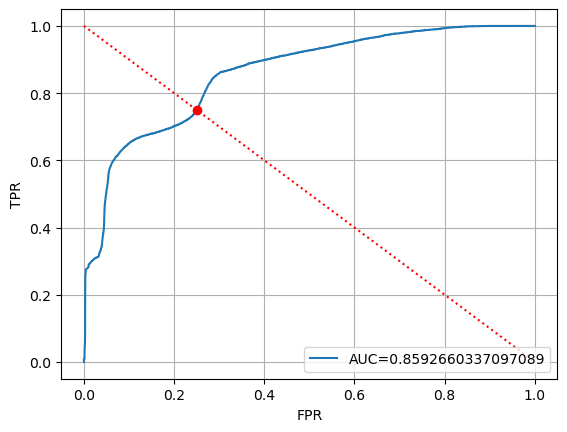

array([0.0090205], dtype=float32)

In [52]:
threshold = ROC(y_test,y_pred)
threshold

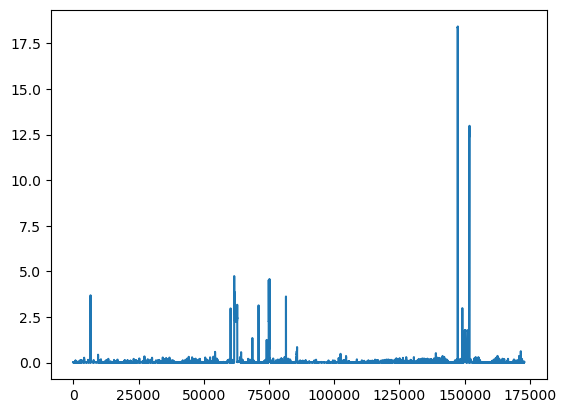

In [23]:
plt.plot(y_pred)

best: 0.029411764705882353 F1: 0.4626454860018874


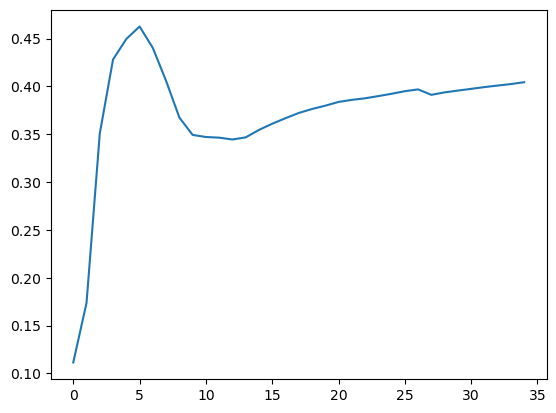

In [56]:
ff = 0
f_history = []
initial_y = 0
best = -1
for inc in np.linspace(0, 0.2, 35):
    y_pred_int = (y_pred > initial_y + inc).astype(int)
    conf_matrix = confusion_matrix(labels, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc + initial_y
print(f'best: {best} F1: {ff}')
plt.plot(f_history)

In [79]:
y_pred_int = np.array((y_pred > best).astype(int))
latency_times = []
for index, (i, j) in enumerate(anomaly_segments):
    current_arr = y_pred_int[i: j]
    first_detection = np.where(current_arr == 1)[0]
    if first_detection.shape[0] > 0:
        latency_times.append(first_detection[0])
        index_of_reference = first_detection[0] + i
        compare_map = np.mean(diagnosis_reference[index_of_reference: index_of_reference + 10], axis=0)
        deviation_factor = compare_map / percentile
        thres = np.quantile(deviation_factor, 0.97)
        print(f'Anomaly number {index}')
        print(np.where(deviation_factor > thres)[0])
        print(deviation_factor[np.where(deviation_factor > thres)[0]])
        # plt.bar(np.arange(len(compare_map)), compare_map / percentile, label='percentile')
        # plt.bar(np.arange(len(compare_map)), compare_map / thresholds, label='max')
        # plt.legend()
        # plt.show()
print(np.mean(latency_times))

Anomaly number 0
[ 5  8 14 96]
[0.50989823 0.55954044 0.43299498 2.32709308]
Anomaly number 1
[ 5 12 14 96]
[1.47766807 0.75894804 0.76884787 0.65750585]
Anomaly number 2
[ 5  8 12 14]
[0.69401163 0.5825338  0.45781815 0.476756  ]
Anomaly number 3
[ 59  69  72 100]
[0.37212442 0.29504265 0.21938455 0.56985775]
Anomaly number 4
[ 34  96 100 111]
[0.54322833 0.64503392 1.20408788 0.88366166]
Anomaly number 5
[  9  10  99 101]
[383.94702644 594.11973065   1.2917446    3.79603861]
Anomaly number 6
[ 10  60  96 106]
[ 0.14442396 54.29048925  0.12190792  0.12600572]
Anomaly number 8
[ 17  58  96 102]
[14851.06953817   120.99396907    40.46363583    23.59996039]
Anomaly number 9
[ 5  8 16 69]
[0.5535958  0.767919   0.96647398 0.51600792]
Anomaly number 10
[37 69 84 96]
[0.2196416  0.20772572 3.09757049 0.25744065]
Anomaly number 11
[ 9 10 60 82]
[ 0.11183246  0.1434613  53.8899245   0.08954201]
Anomaly number 12
[ 5  8 12 14]
[1.28098419 0.30416642 2.02089021 1.31708542]
Anomaly number 13
[ 8

In [81]:
df = pd.read_csv('../../../Projects/data/WADI/WADI_14days_new.csv')
df.columns = df.columns.str.strip()
df = df.drop(columns=na_columns, inplace=False)

In [83]:
df.columns[96]

'2A_AIT_001_PV'

In [88]:
learned_adj = AE1.get_adj()

In [89]:
topk learned_adj[96]

tensor([0.0050, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0001, 0.0141, 0.0000, 0.0007, 0.0000, 0.0016, 0.0107, 0.0003, 0.0005,
        0.0000, 0.0000, 0.0010, 0.0000, 0.0041, 0.0000, 0.0014, 0.0009, 0.0085,
        0.0000, 0.0000, 0.0000, 0.0060, 0.0000, 0.0000, 0.0000, 0.0000, 0.0105,
        0.0000, 0.0004, 0.0040, 0.0051, 0.0032, 0.0055, 0.0003, 0.0000, 0.0000,
        0.0096, 0.0014, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0003, 0.0000,
        0.0000, 0.0019, 0.0000, 0.0012, 0.0000, 0.0000, 0.0000, 0.0000, 0.0052,
        0.0000, 0.0000, 0.0000, 0.0005, 0.0067, 0.0046, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0035, 0.0000, 0.0000, 0.0033, 0.0033, 0.0000, 0.0032, 0.0054,
        0.0000, 0.0000, 0.0068, 0.0068, 0.0000, 0.0000, 0.0000, 0.0000, 0.0025,
        0.0034, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0066, 0.0000,
        0.0067, 0.0077, 0.0008, 0.0028, 0.0039, 0.0000, 0.0045, 0.0000, 0.0026,
        0.0000, 0.0000, 0.0000, 0.0158, 

# Point Adjust

In [59]:
started = False
anomaly_segments = []
for i in range(len(labels)):
    if labels[i] == 1 and not started:
        started = True
        left_side = i
    if labels[i] == 0 and started:
        started = False
        anomaly_segments.append((left_side, i - 1))

In [29]:
len(anomaly_segments)

14

## One point

best: 0.1323529411764706 F1: 0.8507510977582621


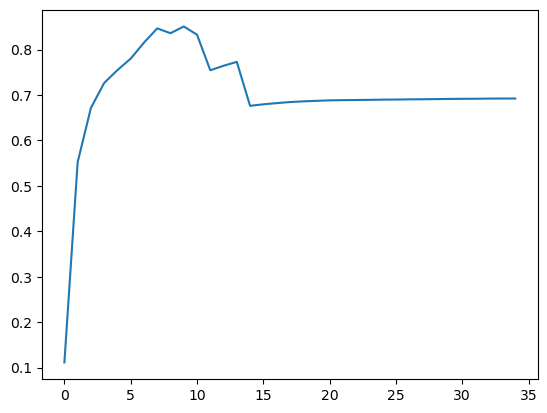

In [30]:
ff = 0
f_history = []
initial_y = 0
best = -1
for inc in np.linspace(0, 0.5, 35):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    for i, j in anomaly_segments:
        if np.sum(y_pred_int[i: j]) > 0:
            y_pred_int[i:j + 1] = [1 for _ in range(j - i + 1)]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc + initial_y
print(f'best: {best} F1: {ff}')
plt.plot(f_history)

## Point adjust 20%

best: 0.4852941176470588 F1: 0.5670061645671403


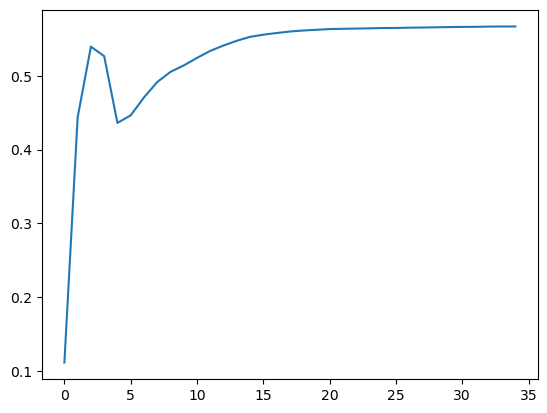

In [31]:
ff = 0
f_history = []
initial_y = 0
best = -1
for inc in np.linspace(0, 0.5, 35):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    for i, j in anomaly_segments:
        if np.sum(y_pred_int[i: j]) / (j - i) > 0.2:
            y_pred_int[i:j + 1] = [1 for _ in range(j - i + 1)]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc + initial_y
print(f'best: {best} F1: {ff}')
plt.plot(f_history)

In [32]:
threshold = np.percentile(y_pred, 75)

excesses = y_pred[y_pred > threshold] - threshold

shape, loc, scale = stats.genpareto.fit(excesses)

desired_quantile = 0.80
quantile = stats.genpareto.ppf(desired_quantile, shape, loc=loc, scale=scale)

final_threshold = threshold + quantile
print(f"Final threshold for anomaly detection: {final_threshold}")
print(f'Initial threshold: {threshold}')
print(f'quantile found: {quantile}')

predicted_labels = (y_pred > final_threshold).astype(int)

Final threshold for anomaly detection: 0.05967290266332884
Initial threshold: 0.009496086277067661
quantile found: 0.05017681638626118


In [33]:
print((classification_report(labels, predicted_labels)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96    162808
           1       0.35      0.33      0.34      9977

    accuracy                           0.93    172785
   macro avg       0.66      0.65      0.65    172785
weighted avg       0.92      0.93      0.93    172785



In [34]:
f1_score(labels, predicted_labels)

0.34150368956086485

In [35]:
len(labels)

172785

In [36]:
len(y_pred)

172785

In [37]:
len(y_test)

172785

In [38]:
# torch.save(AE1.state_dict(), 'GAE_77_Directed_200_epochs.pth')

In [39]:
# AE1.load_state_dict(torch.load('GAE_77_Directed_200_epochs.pth'))

In [40]:
# def testing(loader, alpha=.5, beta=.5):
#     results=[]
#     with torch.no_grad():
#         for batch in loader:
#             w1=AE1(batch)
#             results.append(torch.mean((batch-w1)**2, axis=1))
#     return results

# def get_threshold(val_loader):
#     recon_errors = testing(val_loader)
#     complete_vals = np.concatenate([torch.stack(recon_errors[:-1]).view(-1, num_nodes).detach().cpu().numpy(),
#                                     recon_errors[-1].view(-1, num_nodes).detach().cpu().numpy()])
#     return np.max(complete_vals, axis=0)

In [41]:
# thresholds = get_threshold(validation_loader)
# results=testing(test_loader, alpha=0.3, beta=0.7)
# y_pred=np.concatenate([torch.stack(results[:-1]).view(-1, num_nodes).detach().cpu().numpy(), 
#                        results[-1].view(-1, num_nodes).detach().cpu().numpy()])

In [42]:
# factor = 1

In [43]:
# factor = 720
# res = y_pred > (thresholds * factor)
# boo = np.any(res, axis = 1)
# verdicts = [1 if elem else 0 for elem in boo]
# conf_matrix = confusion_matrix(y_test, verdicts)
# TP = conf_matrix[1, 1]
# TN = conf_matrix[0, 0]
# FP = conf_matrix[0, 1]
# FN = conf_matrix[1, 0]
# F1 = f1_score(y_test, verdicts)
# precision = precision_score(y_test, verdicts)
# recall = recall_score(y_test, verdicts)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", F1)
# print(f'TP: {TP}\nTN: {TN}\nFP: {FP}\nFN: {FN}')
# print(f'Factor is: {factor}')

In [44]:
sum(p.numel() for p in AE1.parameters() if p.requires_grad)

3580188